In [ ]:
!pip install scikit-posthocs

In [ ]:
!pip install pingouin

In [ ]:
!pip install ace_tools

In [ ]:
import pandas as pd
import scipy.stats as stats
import copy
from scipy.stats import shapiro, normaltest, anderson, kstest, norm, spearmanr, levene
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import statsmodels.api as sm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict

import io
import sys
import seaborn as sns
import pingouin as pg

In [ ]:
df_og = pd.read_csv("/content/sample_data/data.csv", sep='\t')
df_og.shape

(19719, 57)

In [ ]:
df_og.head(5)

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,3,53,1,1,1,1,US,4,2,5,...,4,1,3,1,5,1,4,2,5,5
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,3,2,3,3,1,3,2
2,1,14,2,2,1,1,PK,5,1,1,...,4,5,5,1,5,1,5,5,5,5
3,3,19,2,2,1,1,RO,2,5,2,...,4,3,5,2,4,2,5,2,5,5
4,11,25,2,2,1,2,US,3,1,3,...,3,1,1,1,3,1,3,1,5,3


# start processing

we don't care about no sources or hands.

In [ ]:
df_temp = df_og.copy()
df_temp.drop(columns=["source", "hand"], inplace=True)

Missing values are indicated by 0s.

In [ ]:
(df_temp == 0).sum()

,0
race,153
age,0
engnat,70
gender,24
country,0
E1,1
E2,1
E3,1
E4,1
E5,1


In [ ]:
mask = (df_temp.iloc[:, -50:] == 0).all(axis=1)
prob_id = df_temp[mask].index
prob_id

Index([19064], dtype='int64')

In [ ]:
df_temp.iloc[prob_id]

,race,age,engnat,gender,country,E1,E2,E3,E4,E5,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
19064,13,52,2,2,IN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# remove the row index with all zeros
df_temp.drop(index=prob_id, inplace=True)

In [ ]:
summary = pd.DataFrame((df_temp == 0).sum())

# Show only columns where there's at least one zero
summary = summary[(summary[0] > 0)]

summary

,0
race,153
engnat,70
gender,24


In [ ]:
# count values in column age
df_temp["age"].value_counts()

,count
age,
18,1523
17,1370
19,1259
20,1231
21,1216
...,...
266,1
191,1
78,1


In [ ]:
# count how many rows have ages>100 in them
df_temp[df_temp["age"] > 100].shape[0]

83

In [ ]:
df_temp1 = copy.deepcopy(df_temp)

In [ ]:
# Calculate the median age of the entire dataset
median_age = df_temp1['age'].median()
rows_age_120_plus = df_temp1[df_temp1['age'] >= 100]
# Replace ages of 120 or more with the median age
for index in rows_age_120_plus.index:
    df_temp1.loc[index, 'age'] = median_age

In [ ]:
df_temp1[df_temp1["gender"] == 3].shape[0]

102

too small a sample for any interesting conclusions

In [ ]:
# remove gender ==3
df_temp1 = df_temp1[df_temp1["gender"] != 3]

In [ ]:
# Find rows with any zero values
rows_with_zero = df_temp1[(df_temp1 == 0).any(axis=1)]
# Count and print the number of such rows
num_rows = len(rows_with_zero)
print(f"Number of rows with missing value: {num_rows} which is {100 * num_rows / len(df_temp1):.2f}%")

Number of rows with missing value: 241 which is 1.23%


we'll remove those rows for now

In [ ]:
df_temp1.drop(rows_with_zero.index)

,race,age,engnat,gender,country,E1,E2,E3,E4,E5,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,3,53,1,1,US,4,2,5,2,5,...,4,1,3,1,5,1,4,2,5,5
1,13,46,1,2,US,2,2,3,3,3,...,3,3,3,3,2,3,3,1,3,2
2,1,14,2,2,PK,5,1,1,4,5,...,4,5,5,1,5,1,5,5,5,5
3,3,19,2,2,RO,2,5,2,4,3,...,4,3,5,2,4,2,5,2,5,5
4,11,25,2,2,US,3,1,3,3,3,...,3,1,1,1,3,1,3,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19714,11,15,1,2,SG,1,4,3,5,4,...,1,3,5,3,4,1,4,2,5,3
19715,3,37,1,2,US,2,3,2,3,2,...,1,2,3,2,3,3,4,2,3,3
19716,5,16,2,1,US,2,5,4,5,5,...,5,3,1,3,4,1,1,5,5,5
19717,12,16,1,1,NG,1,4,2,3,2,...,3,2,5,3,4,1,5,3,5,5


let's reverse the relevant questions:


In [ ]:
df_temp2 = copy.deepcopy(df_temp1)

In [ ]:
# List of reverse-scored item names (from codebook)
reverse_items = ["E2", "E4", "E6", "E8", "E10",
                 "N2", "N4",
                 "A1", "A3", "A5", "A7",
                 "C2", "C4", "C6", "C8",
                 "O2", "O4", "O6"]

# Apply reverse-scoring: 6 - score
for item in reverse_items:
    if item in df_temp2.columns:
        # Convert columns to numeric before performing subtraction
        df_temp2[item] = pd.to_numeric(df_temp2[item])
        df_temp2[item] = 6 - df_temp2[item]

In [ ]:
# Define the Big Five scales and their item prefixes
scales = {"Extraversion": "E",
          "Neuroticism": "N",
          "Agreeableness": "A",
          "Conscientiousness": "C",
          "Openness": "O"}

In [ ]:
# Loop through each scale and compute Cronbach's alpha
for trait, prefix in scales.items():
    items = [f"{prefix}{i}" for i in range(1, 11)]
    df_trait = df_temp2[items]
    alpha, ci = pg.cronbach_alpha(data=df_trait)
    print(f"Cronbach's alpha for {trait} scale: {alpha:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

Cronbach's alpha for Extraversion scale: 0.892 (95% CI: 0.890–0.894)
Cronbach's alpha for Neuroticism scale: 0.869 (95% CI: 0.867–0.872)
Cronbach's alpha for Agreeableness scale: 0.832 (95% CI: 0.828–0.835)
Cronbach's alpha for Conscientiousness scale: 0.813 (95% CI: 0.809–0.817)
Cronbach's alpha for Openness scale: 0.794 (95% CI: 0.789–0.798)


In [ ]:
# Compute trait scores (row-wise means)
for trait, prefix in scales.items():
    items = [f"{prefix}{i}" for i in range(1, 11)]
    df_temp2[items] = df_temp2[items].apply(pd.to_numeric, errors='coerce')
    df_temp2[trait] = df_temp2[items].mean(axis=1)

# Drop original question columns
all_items = [f"{prefix}{i}" for prefix in scales.values() for i in range(1, 11)]

In [ ]:
df_temp3 = copy.deepcopy(df_temp2)
df_temp3.drop(columns=all_items, inplace=True)

In [ ]:
df_temp3.describe()

,race,age,engnat,gender,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness
count,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000
mean,5.325245,26.262235,1.365416,1.609706,3.014330,3.095493,3.846197,3.348425,3.907540
std,4.018368,11.525280,0.488809,0.490330,0.921332,0.862023,0.713714,0.730766,0.625458
min,0.000000,13.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,18.000000,1.000000,1.000000,2.300000,2.500000,3.400000,2.800000,3.500000
50%,3.000000,22.000000,1.000000,2.000000,3.000000,3.100000,3.900000,3.400000,4.000000
75%,8.000000,31.000000,2.000000,2.000000,3.700000,3.700000,4.400000,3.900000,4.400000
max,13.000000,97.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
# map numeric codes to labels
race_map = {
    1:   "Mixed",
    2:   "Arctic",
    3:   "European",
    4:   "Indian",
    5:   "MiddleEast",
    6:   "NorthAfrican",
    7:   "Indigenous",
    8:   "NativeAmerican",
    9:   "NEAsian",
    10:  "Pacific",
    11:  "SEAsian",
    12:  "African",
    13:  "Other"
}
engnat_map = {
    1: "Native",
    2: "NonNative"
}

gender_map = {
    1: "Male",
    2: "Female",
    3: "Other"
}
df_temp3['race'] = df_temp3['race'].map(race_map)
df_temp3['engnat'] = df_temp3['engnat'].map(engnat_map)
df_temp3['gender'] = df_temp3['gender'].map(gender_map)

In [ ]:
# prompt: # prompt: count rows with col gender = "other"

df_temp3[df_temp3["gender"] == "Other"]

,race,age,engnat,gender,country,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness


In [ ]:
df_data = copy.deepcopy(df_temp3)

In [ ]:
df_data

,race,age,engnat,gender,country,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness
0,European,53,Native,Male,US,4.4,1.1,4.6,4.7,4.3
1,Other,46,Native,Female,US,2.2,3.1,3.5,4.2,2.6
2,Mixed,14,NonNative,Female,PK,3.5,4.6,3.8,4.9,4.5
3,European,19,NonNative,Female,RO,2.2,4.3,3.7,2.6,4.1
4,SEAsian,25,NonNative,Female,US,3.4,3.0,4.4,3.4,3.4
...,...,...,...,...,...,...,...,...,...,...
19714,SEAsian,15,Native,Female,SG,2.1,4.1,4.2,3.6,3.5
19715,European,37,Native,Female,US,2.5,2.1,3.6,3.2,3.0
19716,MiddleEast,16,NonNative,Male,US,2.1,5.0,2.6,2.3,3.7
19717,African,16,Native,Male,NG,2.1,4.0,3.8,4.3,4.2


In [ ]:
# prompt: count how many 'Mixed' in 'race.


In [ ]:
df_data.describe()

,age,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness
count,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000,19616.000000
mean,26.262235,3.014330,3.095493,3.846197,3.348425,3.907540
std,11.525280,0.921332,0.862023,0.713714,0.730766,0.625458
min,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,18.000000,2.300000,2.500000,3.400000,2.800000,3.500000
50%,22.000000,3.000000,3.100000,3.900000,3.400000,4.000000
75%,31.000000,3.700000,3.700000,4.400000,3.900000,4.400000
max,97.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
# df_data.to_csv("df_data.csv", index=False)

In [ ]:
# Standardize capitalization in the 'race' column
df_data['race'] = df_data['race'].str.capitalize()

# Display value counts to confirm the change
print(df_data['race'].value_counts())

race
European          10482
Other              2539
Seasian            1853
Indian             1516
Mixed              1419
Middleeast          515
Northafrican        397
African             258
Nativeamerican      198
Neasian             186
Pacific              65
Indigenous           22
Arctic               13
Name: count, dtype: int64


# Data Visualization

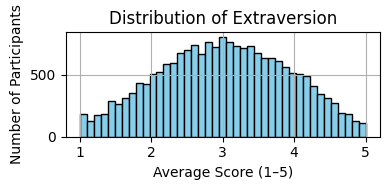

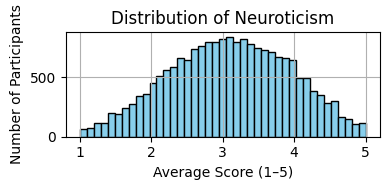

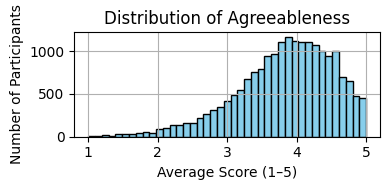

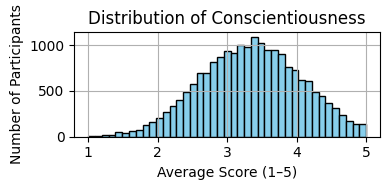

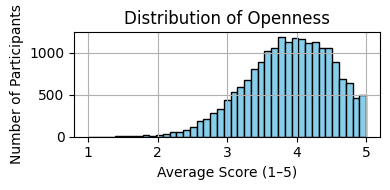

In [ ]:
# List of numeric columns
numeric_colunms = ["Extraversion", "Neuroticism", "Agreeableness", "Conscientiousness", "Openness"]

# Plot histogram for each trait
for trait in numeric_colunms:
    plt.figure(figsize=(4, 2))
    df_data[trait].hist(bins=41, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {trait}")
    plt.xlabel("Average Score (1–5)")
    plt.ylabel("Number of Participants")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

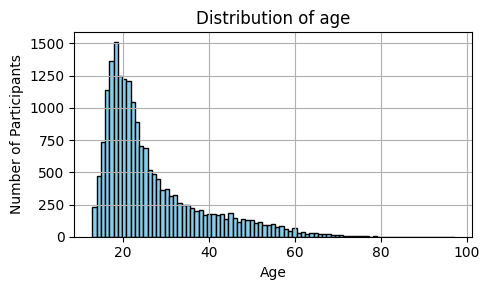

In [ ]:
plt.figure(figsize=(5, 3))
df_data["age"].hist(bins=85, color='skyblue', edgecolor='black')
plt.title(f"Distribution of age")
plt.xlabel("Age")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
categorical_cols = df_data.iloc[:, [0, 2, 3, 4]]
numerical_cols = df_data.drop(columns=categorical_cols.columns)

In [ ]:
# Print value counts for each column
for col in categorical_cols:
    print(df_data[col].value_counts())
    print()

race
European          10482
Other              2539
Seasian            1853
Indian             1516
Mixed              1419
Middleeast          515
Northafrican        397
African             258
Nativeamerican      198
Neasian             186
Pacific              65
Indigenous           22
Arctic               13
Name: count, dtype: int64

engnat
Native       12310
NonNative     7237
Name: count, dtype: int64

gender
Female    11984
Male       7608
Name: count, dtype: int64

country
US    8695
GB    1524
IN    1462
AU     972
CA     916
      ... 
CV       1
MR       1
UZ       1
TC       1
KG       1
Name: count, Length: 158, dtype: int64



Race and country distributions might pose a problem with certain tests... But we'll deal with that later

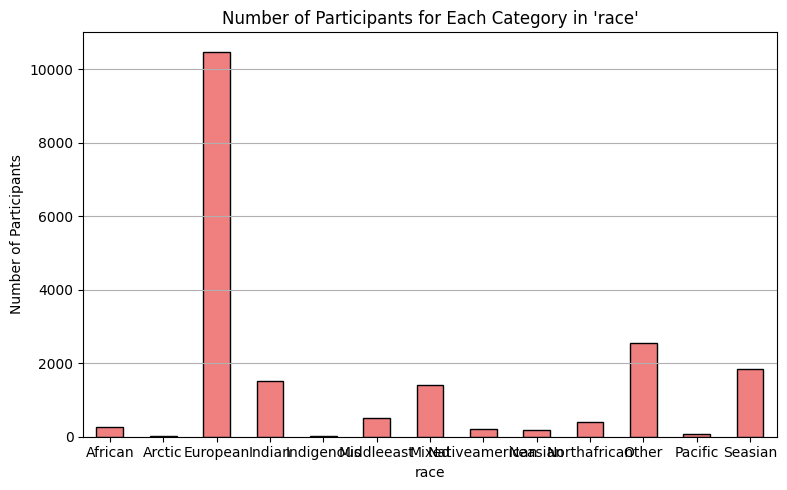

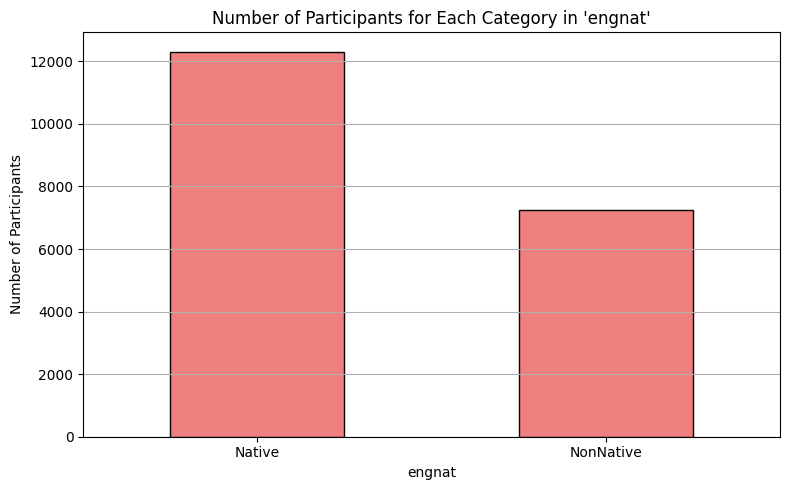

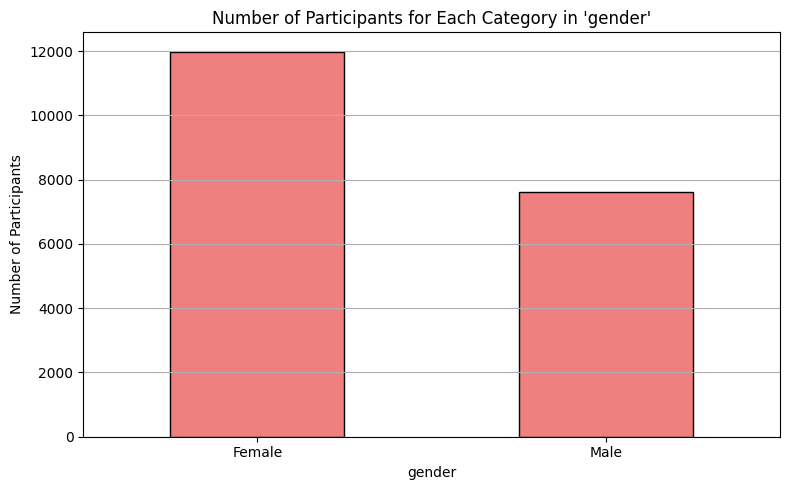

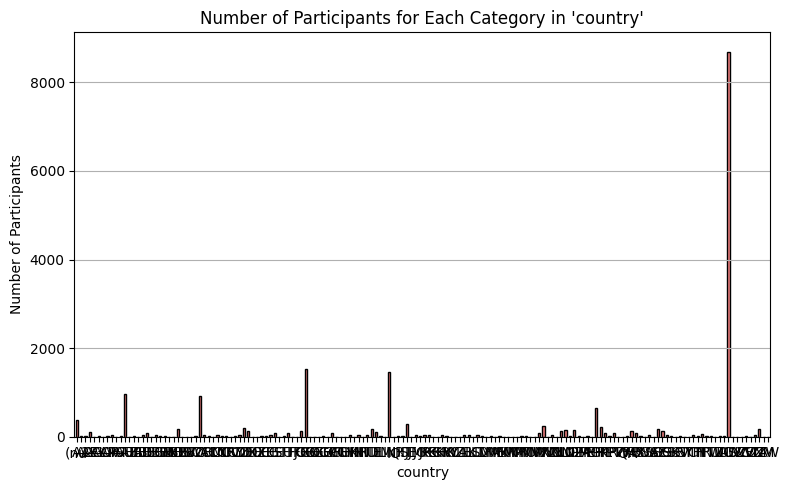

In [ ]:
# Plot count of participants for each unique value in each categorical column
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    df_data[col].value_counts().sort_index().plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title(f"Number of Participants for Each Category in '{col}'")
    plt.xlabel(col)
    plt.ylabel("Number of Participants")
    plt.xticks(rotation=0) # Keep x-axis labels horizontal for readability
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# prompt: I want to copt df_no_numeric_outliers, call it df_final: in race, for all catagories with less then 200 rows, label as "other". same with countries. with gender: for rows  labeled 3: randomaly cahnge 59 of them to 2 and the others to 1
# Process 'race' column
race_counts = df_data['race'].value_counts()
races_to_other = race_counts[race_counts < 200].index
df_data['race'] = df_data['race'].replace(races_to_other, 'Other')
# Convert to categorical to handle sorting of mixed types
df_data['race'] = df_data['race'].astype('category')


# Process 'country' column
country_counts = df_data['country'].value_counts()
countries_to_other = country_counts[country_counts < 200].index
df_data['country'] = df_data['country'].replace(countries_to_other, 'Other')
# Convert to categorical to handle sorting of mixed types
df_data['country'] = df_data['country'].astype('category')


# Process 'gender' column
gender_3_indices = df_data[df_data['gender'] == 3].index
num_gender_3 = len(gender_3_indices)

if num_gender_3 > 0:
    # Number to change to 2
    num_to_2 = min(59, num_gender_3)

    # Randomly select indices to change to 2
    indices_to_2 = np.random.choice(gender_3_indices, size=num_to_2, replace=False)

    # Get indices to change to 1 (the rest of gender 3)
    indices_to_1 = gender_3_indices.difference(indices_to_2)

    # Apply the changes
    df_data.loc[indices_to_2, 'gender'] = 2
    df_data.loc[indices_to_1, 'gender'] = 1
    # Convert gender to category as well
    df_data['gender'] = df_data['gender'].astype('category')


print("\nProcessed 'race', 'country', and 'gender' columns.")
print("\nValue counts after processing:")
print("\nRace counts:")
print(df_data['race'].value_counts())
print("\nCountry counts:")
print(df_data['country'].value_counts())
print("\nGender counts:")
print(df_data['gender'].value_counts())


Processed 'race', 'country', and 'gender' columns.

Value counts after processing:

Race counts:
race
European        10482
Other            3023
Seasian          1853
Indian           1516
Mixed            1419
Middleeast        515
Northafrican      397
African           258
Name: count, dtype: int64

Country counts:
country
US       8695
Other    4279
GB       1524
IN       1462
AU        972
CA        916
PH        645
(nu       369
IT        276
MY        247
PK        222
Name: count, dtype: int64

Gender counts:
gender
Female    11984
Male       7608
Name: count, dtype: int64


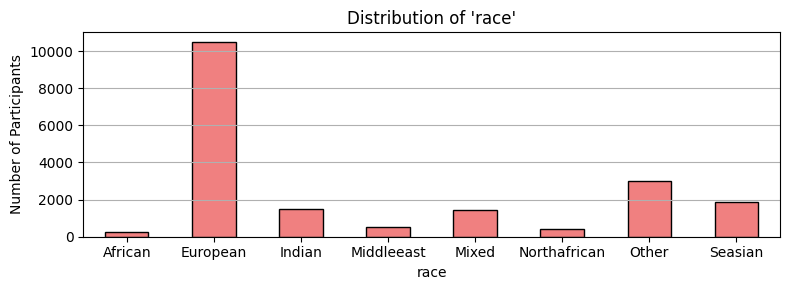

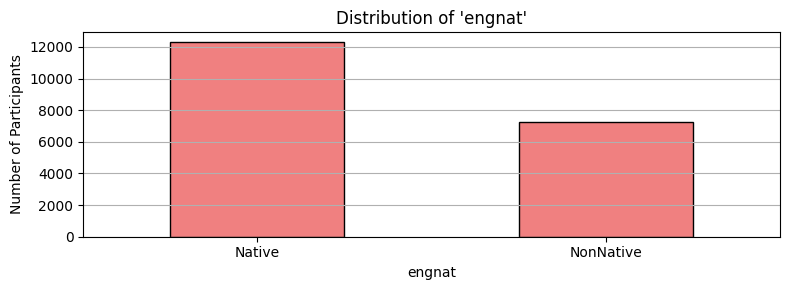

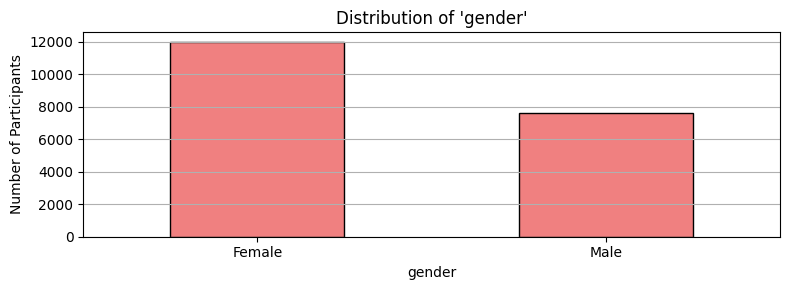

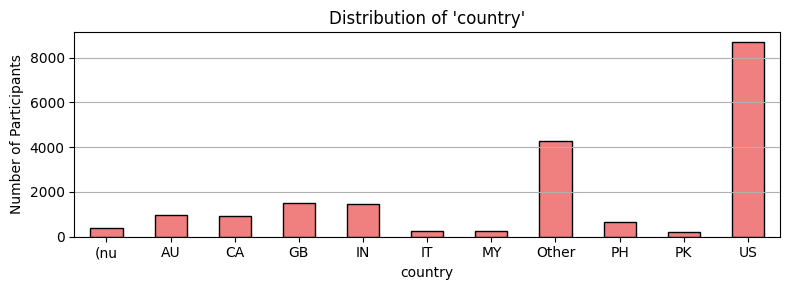

In [ ]:
# Plot count of participants for each unique value in each categorical column
for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    df_data[col].value_counts().sort_index().plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Number of Participants")
    plt.xticks(rotation=0) # Keep x-axis labels horizontal for readability
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

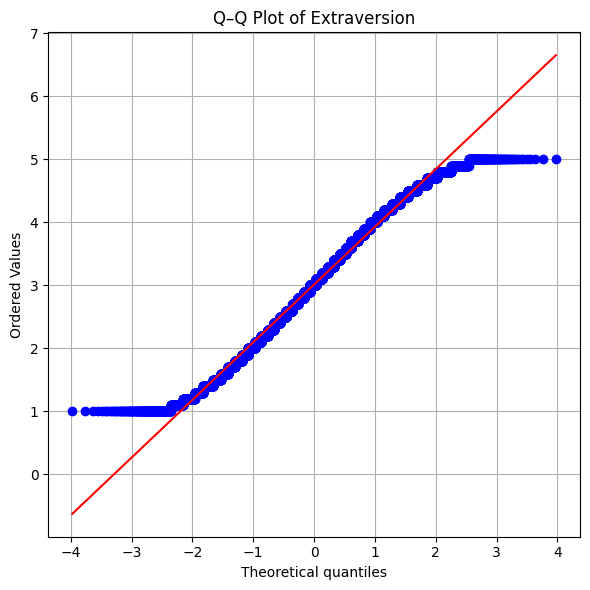

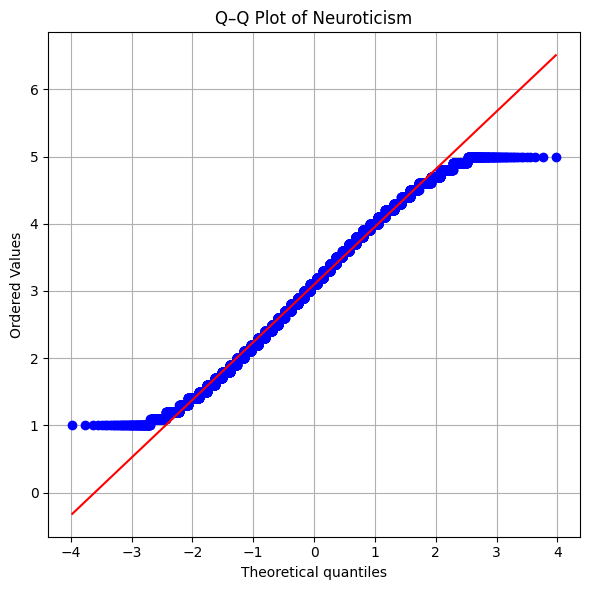

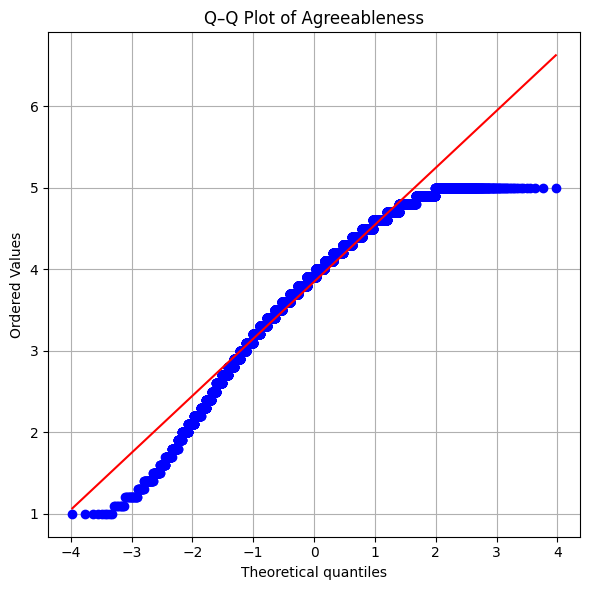

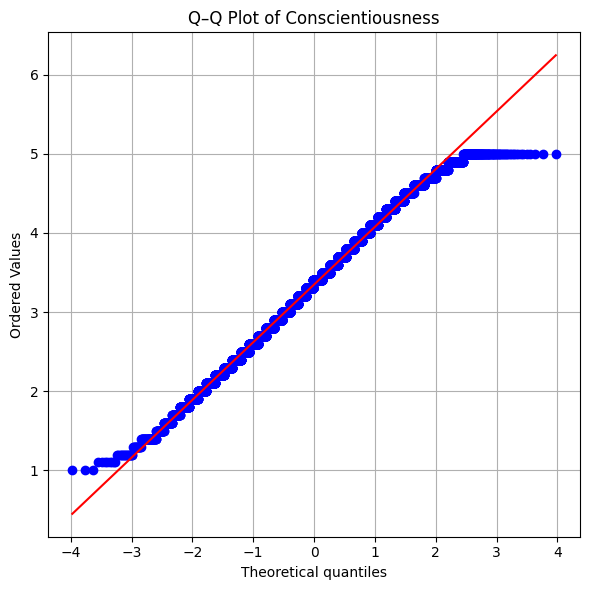

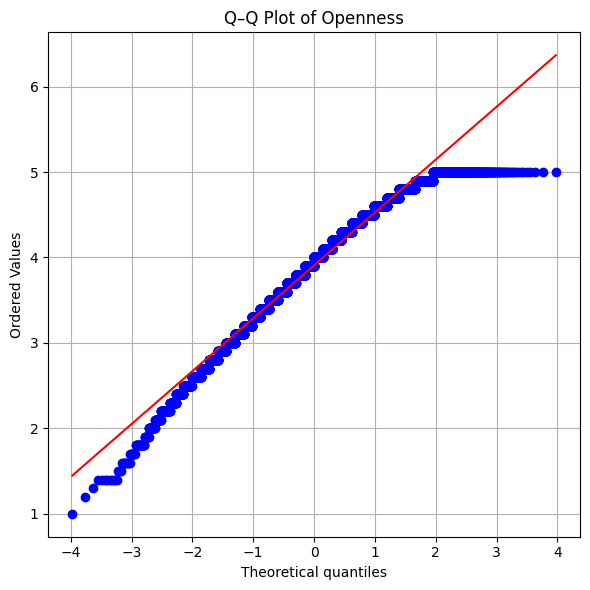

In [ ]:
# Generate Q-Q plot for each trait
for trait in numerical_cols.iloc[:, 1:]:
    plt.figure(figsize=(6, 6))
    stats.probplot(df_data[trait], dist="norm", plot=plt)
    plt.title(f"Q–Q Plot of {trait}")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"{trait}_QQplot.png", dpi=300)  # You can also provide a full path if needed

    plt.show()

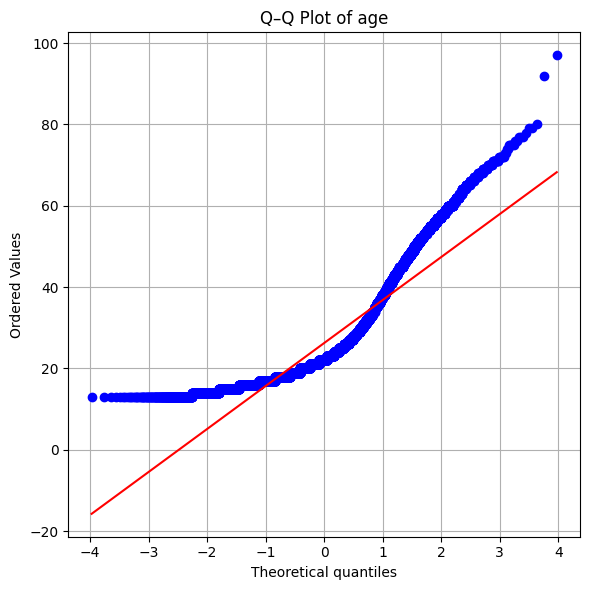

In [ ]:
# Generate Q-Q plot for each trait
trait = "age"
plt.figure(figsize=(6, 6))
stats.probplot(df_data[trait], dist="norm", plot=plt)
plt.title(f"Q–Q Plot of {trait}")
plt.grid(True)
plt.tight_layout()
plt.show()

Quite obiviously not normal

# TESTS

In [ ]:
# Run all normality tests per trait
for trait in numeric_colunms:
    data = df_data[trait].dropna()

    print(f"\n{trait}:")

    # Shapiro–Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk:       W = {stat:.3f}, p = {p:.3g} → {'Not normal' if p < 0.05 else 'Normal'}")

    # D’Agostino and Pearson’s Test
    stat, p = normaltest(data)
    print(f"D’Agostino-Pearson: stat = {stat:.3f}, p = {p:.3g} → {'Not normal' if p < 0.05 else 'Normal'}")

    # Anderson–Darling Test
    result = anderson(data, dist='norm')
    critical_value = result.critical_values[2]  # 5% significance level
    print(f"Anderson-Darling:   A² = {result.statistic:.3f}, critical @5% = {critical_value:.3f} → "
          f"{'Not normal' if result.statistic > critical_value else 'Normal'}")

    # Kolmogorov–Smirnov Test
    stat, p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"Kolmogorov–Smirnov: D = {stat:.3f}, p = {p:.3g} → {'Not normal' if p < 0.05 else 'Normal'}")



Extraversion:
Shapiro-Wilk:       W = 0.988, p = 3.44e-37 → Not normal
D’Agostino-Pearson: stat = 1095.813, p = 1.11e-238 → Not normal
Anderson-Darling:   A² = 43.459, critical @5% = 0.787 → Not normal
Kolmogorov–Smirnov: D = 0.041, p = 1.88e-29 → Not normal

Neuroticism:
Shapiro-Wilk:       W = 0.991, p = 8.59e-33 → Not normal
D’Agostino-Pearson: stat = 670.409, p = 2.65e-146 → Not normal
Anderson-Darling:   A² = 34.680, critical @5% = 0.787 → Not normal
Kolmogorov–Smirnov: D = 0.042, p = 8e-30 → Not normal

Agreeableness:
Shapiro-Wilk:       W = 0.960, p = 9.21e-58 → Not normal
D’Agostino-Pearson: stat = 1676.391, p = 0 → Not normal
Anderson-Darling:   A² = 165.270, critical @5% = 0.787 → Not normal
Kolmogorov–Smirnov: D = 0.078, p = 2.64e-105 → Not normal

Conscientiousness:
Shapiro-Wilk:       W = 0.995, p = 3.8e-26 → Not normal
D’Agostino-Pearson: stat = 205.108, p = 2.89e-45 → Not normal
Anderson-Darling:   A² = 22.875, critical @5% = 0.787 → Not normal


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19616.
  res = hypotest_fun_out(*samples, **kwds)


Kolmogorov–Smirnov: D = 0.034, p = 1.17e-20 → Not normal

Openness:
Shapiro-Wilk:       W = 0.979, p = 1.79e-46 → Not normal
D’Agostino-Pearson: stat = 654.318, p = 8.25e-143 → Not normal
Anderson-Darling:   A² = 84.055, critical @5% = 0.787 → Not normal
Kolmogorov–Smirnov: D = 0.063, p = 2.51e-68 → Not normal


In [ ]:
# 1. Prepare data
df = df_data[['age','Neuroticism']].dropna()
x = df['age']
y = df['Neuroticism']
n = len(df)

In [ ]:
# 2. Pearson correlation (two‐sided + one‐sided UMP)
r, p_two = stats.pearsonr(x, y)
p_one = p_two/2 if r>0 else 1 - p_two/2
display(f"Pearson r = {r:.3f}, two-sided p = {p_two:.3g}  # UMP")
z        = np.arctanh(r)
se       = 1/np.sqrt(n - 3)
z_crit   = stats.norm.ppf(0.975)
ci_low   = np.tanh(z - z_crit*se)
ci_high  = np.tanh(z + z_crit*se)
display(f"95% CI for Pearson r = [{ci_low:.3f}, {ci_high:.3f}]")

'Pearson r = -0.162, two-sided p = 8.86e-115  # UMP'

'95% CI for Pearson r = [-0.175, -0.148]'

In [ ]:
# Drop rows with missing values in either column
subset = df_data[['age', 'Neuroticism']].dropna()

# Calculate Spearman correlation
corr, p_value = spearmanr(subset['age'], subset['Neuroticism'])

# display results
display(f"Spearman Rao: ρ = {corr:.3f}, p = {p_value:.4f}")

# 3. Asymptotic (Fisher) 95% CI for ρ
z, se = np.arctanh(r), 1/np.sqrt(n-3)
crit = stats.norm.ppf(0.975)
ci_r = (np.tanh(z - crit*se), np.tanh(z + crit*se))
display(f"Asymptotic (Fisher) 95% CI for r = [{ci_r[0]:.3f}, {ci_r[1]:.3f}]")  # asymptotic CI

# 6. Bootstrap CI for r (CAN estimator & percentile)
B = 2000
r_bs = []
for _ in range(B):
    idx = np.random.choice(n, n, replace=True)
    r_bs.append(np.corrcoef(x.iloc[idx], y.iloc[idx])[0,1])
ci_bs = np.percentile(r_bs, [2.5, 97.5])
display(f"Bootstrap 95% CI for r = [{ci_bs[0]:.3f}, {ci_bs[1]:.3f}]")

'Spearman Rao: ρ = -0.155, p = 0.0000'

'Asymptotic (Fisher) 95% CI for r = [-0.175, -0.148]'

'Bootstrap 95% CI for r = [-0.175, -0.148]'

In [ ]:
# Subset the extroversion scores by gender
male_scores = df_data[df_data["gender"] == "Male"]["Extraversion"]
female_scores = df_data[df_data["gender"] == "Female"]["Extraversion"]

In [ ]:
# Run the Mann–Whitney U test
statistic, p_value = stats.mannwhitneyu(male_scores, female_scores, alternative="two-sided")

# Report the result
print("p-value: %.4f" % p_value)
if p_value < 0.05:
    print("Reject null hypothesis: there is a significant difference in extroversion between males and females.")
else:
    print("Fail to reject null hypothesis: no significant difference in extroversion between males and females.")
print("Median male extroversion:", male_scores.median())
print("Median female extroversion:", female_scores.median())

p-value: 0.0000
Reject null hypothesis: there is a significant difference in extroversion between males and females.
Median male extroversion: 2.9
Median female extroversion: 3.1


In [ ]:
# Subset the extroversion scores by gender
male_scores = df_data[df_data["gender"] == "Male"]["Extraversion"]
female_scores = df_data[df_data["gender"] == "Female"]["Extraversion"]

# Run the Mann–Whitney U test
statistic, p_value = stats.mannwhitneyu(
    male_scores,
    female_scores,
    alternative="two-sided"
)

# Report the result with normal prints
display(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    display("Reject H_0: there is a significant difference in extroversion between males and females.")
else:
    display("Fail to reject H_0: no significant difference in extroversion between males and females.")
display("Median male extroversion:", male_scores.median())
display("Median female extroversion:", female_scores.median())

'p-value: 0.0000'

'Reject H_0: there is a significant difference in extroversion between males and females.'

'Median male extroversion:'

2.9

'Median female extroversion:'

3.1

# new main

In [ ]:
# create a new df called df_data2 without the 'other's in the 'race'
df_data2 = df_data[~df_data['race'].isin(['Other' , 'Mixed'])].copy()

In [ ]:
# remove unused categories of race cuz apparently thats a thing
df_data2['race'] = df_data2['race'].cat.remove_unused_categories()

In [ ]:
df_data2.groupby('race')['Openness'].median()

/tmp/ipython-input-2911913078.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_data2.groupby('race')['Openness'].median()


,Openness
race,
African,4.0
European,4.1
Indian,3.7
Middleeast,3.8
Northafrican,3.9
Seasian,3.7


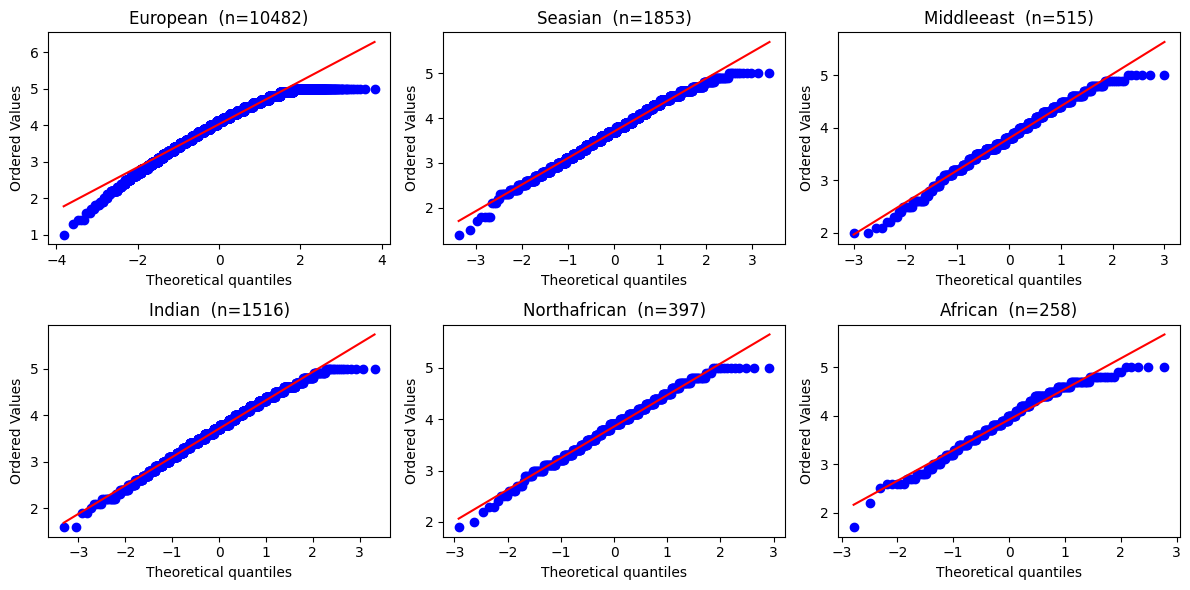

In [ ]:
races = df_data2['race'].dropna().unique()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, race in zip(axes, races):
    vals = df_data2.loc[df_data2['race'] == race, 'Openness'].dropna()
    stats.probplot(vals, dist="norm", plot=ax)
    ax.set_title(f"{race}  (n={len(vals)})")

plt.tight_layout()
plt.show()

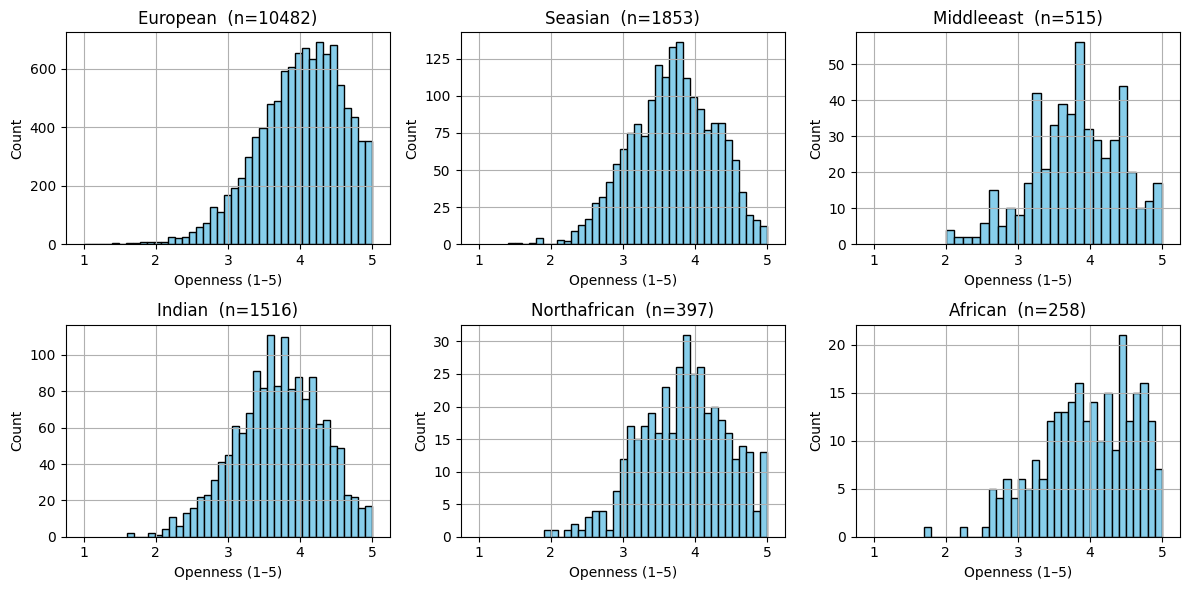

In [ ]:
bins_list = [41, 37, 25, 35, 32, 33]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, race, bins in zip(axes, races, bins_list):
    vals = df_data2.loc[df_data2['race'] == race, 'Openness'].dropna()
    ax.hist(vals, bins=bins, color='skyblue', edgecolor='black')
    ax.set_title(f"{race}  (n={len(vals)})")
    ax.set_xlabel("Openness (1–5)")
    ax.set_ylabel("Count")
    ax.set_xlim(0.75, 5.25)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# run test epsilon squared for Openness with respect to 'race'
# collect the data vectors for each race
groups = [grp["Openness"].dropna().values for _, grp in df_data.groupby('race', observed=True)]
# kruskal‐wallis test
H, p = stats.kruskal(*groups)
k = len(groups)
n = sum(len(g) for g in groups)
# epsilon‐squared effect size
eps2 = (H - k + 1) / (n - k)
print(f"H = {H:.2f}, p = {p:.3g}, ε² = {eps2:.3f}")

H = 1045.06, p = 2.21e-221, ε² = 0.053


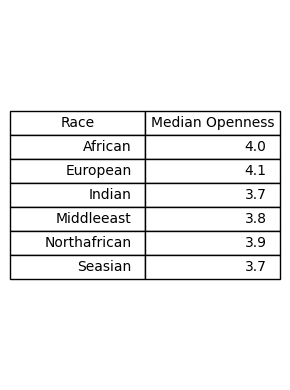

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# PNG table of median Openness by race + download
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Build the median table
med_df = (
    df_data2[['race','Openness']]
    .dropna(subset=['race','Openness'])
    .assign(race=lambda d: d['race'].astype(str))
    .groupby('race', as_index=False)['Openness'].median()
    .rename(columns={'race': 'Race', 'Openness': 'Median Openness'})
    .sort_values('Race')  # or .sort_values('Median Openness', ascending=False)
)
med_df['Median Openness'] = med_df['Median Openness'].round(3)

# Figure size scales with number of rows
n = len(med_df)
fig_w = 3
fig_h = max(2.5, 0.5 * n + 1)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')

table = ax.table(
    cellText=med_df.values,
    colLabels=med_df.columns.tolist(),
    loc='center'
)

# Tweak appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)  # make rows taller

out_png = "median_openness.png"
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()

# Download the PNG
files.download(out_png)



$H_0$: All races have the same median Openness.<br>
$H_1$: At least one race has different median Openness.

In [ ]:
# Group Openness scores by race
groups = [group['Openness'].values for _, group in df_data.groupby('race', observed=True)]

# Run Kruskal–Wallis test
H_statistic, p_value = stats.kruskal(*groups)

print("p value: %.6f" % p_value)
if p_value < 0.05:
    print("Reject null hypothesis – at least one race differs in Openness.")
else:
    print("Fail to reject null hypothesis – no significant difference in Openness by race.")


p value: 0.000000
Reject null hypothesis – at least one race differs in Openness.


In [ ]:
from itertools import combinations
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Clean data
data = df_data2[['race', 'Openness']].dropna(subset=['race', 'Openness']).copy()
data['race'] = data['race'].astype(str)
groups = data['race'].unique()

def permutation_test_median(x, y, B=30000, seed=42):
    """
    Two-sided permutation test on the MEDIAN difference (x - y).
    Preserves group sizes; returns (p_value, observed_median_diff).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    n_x = len(x); n_y = len(y)

    obs = np.median(x) - np.median(y)

    pooled = np.concatenate([x, y])
    idx = np.arange(pooled.size)

    extreme = 0
    for _ in range(B):
        rng.shuffle(idx)
        x_ = pooled[idx[:n_x]]
        y_ = pooled[idx[n_x:]]
        stat = np.median(x_) - np.median(y_)
        if abs(stat) >= abs(obs):
            extreme += 1

    # small-sample adjusted p
    pval = (extreme + 1) / (B + 1)
    return pval, obs

# Pairwise tests
rows = []
for g1, g2 in combinations(groups, 2):
    x = data.loc[data['race'] == g1, 'Openness'].to_numpy()
    y = data.loc[data['race'] == g2, 'Openness'].to_numpy()
    if len(x) == 0 or len(y) == 0:
        continue
    p, obs = permutation_test_median(x, y, B=30000, seed=42)
    rows.append({
        "Race 1": g1,
        "Race 2": g2,
        "Observed Median Difference": obs,  # g1 - g2
        "p-value": p
    })

results_tbl = pd.DataFrame(rows)

# Holm correction
rej, p_holm, *_ = multipletests(results_tbl["p-value"], method='holm')
results_tbl["p-value (Holm)"] = p_holm
results_tbl["Significant (Holm, α=0.05)"] = rej

# Inspect
print(results_tbl.sort_values("p-value (Holm)").head(10))


        Race 1        Race 2  Observed Median Difference   p-value  \
0     European       Seasian                         0.4  0.000033   
1     European    Middleeast                         0.3  0.000033   
2     European        Indian                         0.4  0.000033   
8      Seasian       African                        -0.3  0.000033   
13      Indian       African                        -0.3  0.000067   
3     European  Northafrican                         0.2  0.000500   
7      Seasian  Northafrican                        -0.2  0.002233   
12      Indian  Northafrican                        -0.2  0.004267   
11  Middleeast       African                        -0.2  0.021366   
6      Seasian        Indian                         0.0  1.000000   

    p-value (Holm)  Significant (Holm, α=0.05)  
0         0.000500                        True  
1         0.000500                        True  
2         0.000500                        True  
8         0.000500               

In [ ]:
# === Build Holm-adjusted p-value table (races × races) ===
import numpy as np
import pandas as pd
from IPython.display import display

alpha = 0.05

# Use all races that appear in results_tbl (stable order)
races = sorted(pd.unique(pd.concat([results_tbl['Race 1'], results_tbl['Race 2']]).dropna().astype(str)))

# Square table
p_table_holm = pd.DataFrame(index=races, columns=races, dtype=float)

# Fill symmetric entries from results_tbl (Holm-adjusted)
for _, row in results_tbl.iterrows():
    r1, r2 = str(row['Race 1']), str(row['Race 2'])
    p = float(row['p-value (Holm)'])
    p_table_holm.loc[r1, r2] = p
    p_table_holm.loc[r2, r1] = p

# Diagonal = NaN (no self-comparison)
np.fill_diagonal(p_table_holm.values, np.nan)

# Optional: highlight significant (pink)
def pink_if_sig(v, a=alpha):
    if pd.isna(v): return ''
    return 'background-color: pink; font-weight: 600;' if v <= a else ''

display(p_table_holm.style.applymap(pink_if_sig).format('{:.3f}'))

# Optional: save to CSV
# p_table_holm.to_csv('p_table_holm.csv', index=True)


/tmp/ipython-input-3467855338.py:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(p_table_holm.style.applymap(pink_if_sig).format('{:.3f}'))


,African,European,Indian,Middleeast,Northafrican,Seasian
African,nan,1.000,0.001,0.150,1.000,0.000
European,1.000,nan,0.000,0.000,0.005,0.000
Indian,0.001,0.000,nan,1.000,0.034,1.000
Middleeast,0.150,0.000,1.000,nan,1.000,1.000
Northafrican,1.000,0.005,0.034,1.000,nan,0.020
Seasian,0.000,0.000,1.000,1.000,0.020,nan


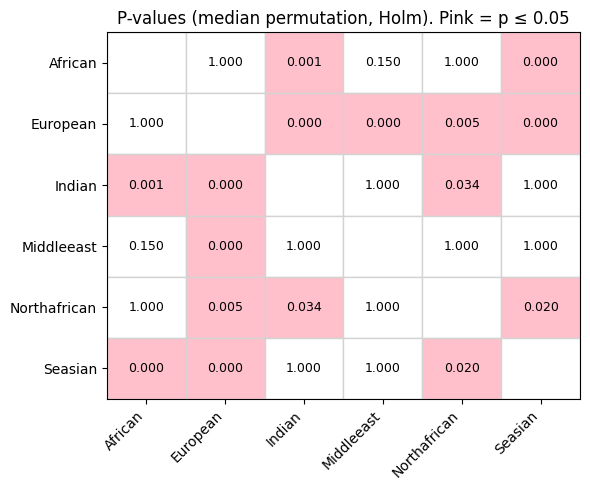

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Cell 1: Build Holm-adjusted p-value table and plot it (pink = significant) ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files

alpha = 0.05
dpi_save = 300

# Races order (stable & consistent across plots)
races = sorted(data['race'].unique())

# Square p-value table (Holm)
p_table = pd.DataFrame(index=races, columns=races, dtype=float)
for _, r in results_tbl.iterrows():
    r1, r2 = r['Race 1'], r['Race 2']
    p = r['p-value (Holm)'] if 'p-value (Holm)' in results_tbl.columns else r['p-value']
    p_table.loc[r1, r2] = p
    p_table.loc[r2, r1] = p
np.fill_diagonal(p_table.values, np.nan)

# Plot as a grid with pink significant cells
fig, ax = plt.subplots(figsize=(max(6, 0.6*len(races)), max(5, 0.6*len(races))))
ax.set_xlim(0, len(races)); ax.set_ylim(0, len(races)); ax.invert_yaxis()

for i, ri in enumerate(races):
    for j, rj in enumerate(races):
        val = p_table.iloc[i, j]
        face = "white" if (i == j or pd.isna(val) or val > alpha) else "pink"
        text = "" if (i == j or pd.isna(val)) else f"{val:.3f}"
        rect = patches.Rectangle((j, i), 1, 1, facecolor=face, edgecolor="lightgray")
        ax.add_patch(rect)
        if text:
            ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", fontsize=9)

ax.set_xticks(np.arange(len(races)) + 0.5)
ax.set_yticks(np.arange(len(races)) + 0.5)
ax.set_xticklabels(races, rotation=45, ha="right")
ax.set_yticklabels(races)
ax.set_title(f"P-values (median permutation, Holm). Pink = p ≤ {alpha}")

for k in range(len(races) + 1):
    ax.axhline(k, color="lightgray", linewidth=0.6)
    ax.axvline(k, color="lightgray", linewidth=0.6)

plt.tight_layout()
out1 = "p_values_median_heatmap.png"
plt.savefig(out1, dpi=dpi_save, bbox_inches="tight")
plt.show()

files.download(out1)


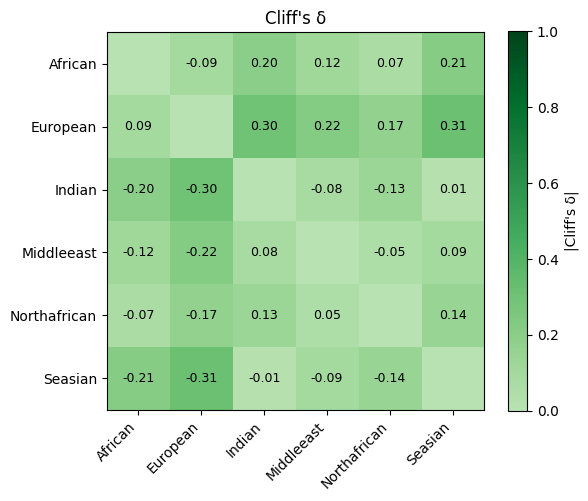

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Cell 2: Cliff's delta heatmap (Greens) + PNG download ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import combinations
from google.colab import files

# Cliff's delta (efficient, handles ties)
def cliffs_delta(x, y):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    n_x, n_y = len(x), len(y)
    y_sorted = np.sort(y)
    less = np.searchsorted(y_sorted, x, side='left')
    leq  = np.searchsorted(y_sorted, x, side='right')
    greater = n_y - leq
    num = np.sum(less - greater)  # ties contribute 0
    return num / (n_x * n_y)

# Build square δ table (row vs column)
delta_table = pd.DataFrame(index=races, columns=races, dtype=float)
for g1, g2 in combinations(races, 2):
    x = data.loc[data['race'] == g1, 'Openness'].to_numpy()
    y = data.loc[data['race'] == g2, 'Openness'].to_numpy()
    d = cliffs_delta(x, y)
    delta_table.loc[g1, g2] = d
    delta_table.loc[g2, g1] = -d
np.fill_diagonal(delta_table.values, 0.0)

# Lighten Greens so text is readable
orig = plt.get_cmap("Greens")
light_greens = mcolors.LinearSegmentedColormap.from_list(
    "light_greens", orig(np.linspace(0.3, 1.0, 256))
)

delta_abs = np.abs(delta_table.values.astype(float))

fig, ax = plt.subplots(figsize=(max(6, 0.6*len(races)), max(5, 0.6*len(races))))
im = ax.imshow(delta_abs, vmin=0, vmax=1.0, cmap=light_greens, origin="upper")

# Annotate with signed δ
for i in range(len(races)):
    for j in range(len(races)):
        val = delta_table.iloc[i, j]
        if i != j and np.isfinite(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color="black")

ax.set_xticks(np.arange(len(races)))
ax.set_yticks(np.arange(len(races)))
ax.set_xticklabels(races, rotation=45, ha="right")
ax.set_yticklabels(races)
ax.set_title("Cliff's δ")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("|Cliff's δ|", rotation=90)

plt.tight_layout()
out2 = "cliffs_delta_heatmap.png"
plt.savefig(out2, dpi=300, bbox_inches="tight")
plt.show()

files.download(out2)


In [99]:
def prob_superiority_with_ties(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    b_sorted = np.sort(b)
    lt = np.searchsorted(b_sorted, a, side='left')   # count of b < a, per a
    le = np.searchsorted(b_sorted, a, side='right')  # count of b <= a, per a
    Ngt = lt.sum()
    Neq = (le - lt).sum()
    Nlt = (b.size - le).sum()
    nm = a.size * b.size

    p_gt = Ngt / nm
    p_eq = Neq / nm
    p_sup = (Ngt + 0.5*Neq) / nm              # P(A>B) + 0.5 P(A=B)
    delta = (Ngt - Nlt) / nm                  # Cliff's δ
    return p_gt, p_eq, p_sup, delta

# Example on your dataframe:
# df has columns 'race' and 'Openness'
indians = df_data2.loc[df_data2['race'] == 'Indian', 'Openness'].dropna().to_numpy()
europeans = df_data2.loc[df_data2['race'] == 'European', 'Openness'].dropna().to_numpy()

p_gt, p_eq, p_sup, delta = prob_superiority_with_ties(indians, europeans)
print(f"P(Indian > European) = {p_gt:.6f}")
print(f"P(Indian = European) = {p_eq:.6f}")
print(f"Probability of superiority = {p_sup:.6f}")  # includes 0.5 * ties
print(f"Cliff's delta δ = {delta:.6f}; (δ+1)/2 = {(delta+1)/2:.6f}")


P(Indian > European) = 0.329899
P(Indian = European) = 0.042880
Probability of superiority = 0.351339
Cliff's delta δ = -0.297322; (δ+1)/2 = 0.351339
